#### Constraining inventory to the TSCA actives for centroid and MaxMin selection

Created by: Grace Patlewicz<br>
Last modified: 10 May 2024<br>
Changes: Re-analysed based on April inventory.

This notebook considers the PFAS Landscape with the contraint that only substances on the active inventory should be considered. Centroids and additional diverse substances are identified and these are captured with the sets of chemical identified from the main unconstrained inventory.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform
import sys

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [3]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [4]:
from model_functions import *

In [5]:
df = pd.read_excel(interim_dir+'final_universe_categorisatons_wtsca_constraints_100524.xlsx')

In [6]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.head()

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,Substance_Note,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,...,final_dist,group,group_str,MaxMin_picks,tsca_centroid,tsca_centroid_id,tsca_centroid_id2,tsca_analogues,tsca_dist,MaxMin_tsca_picks
0,IROQAHVXXUQBOS-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,CCCN(CCNC(=O)c1ccc(Cc2ccc(C(O)=O)cc2)cc1)S(=O)...,NaN,NaN,NaN,...,0.000000,"('Aromatic PFASs', 'gte7', nan, nan)","('Aromatic PFASs', 'gte7', nan, nan)",1,NaN,NaN,NaN,NaN,NaN,NaN
1,DTXSID90897582,DSSTox_High,4-(Perfluorononyl)oxybenzenesulfonate sodium,91998-13-9,Single Compound,NaN,[Na+].[O-]S(=O)(=O)C1=CC=C(OC(F)(F)C(F)(F)C(F)...,"InChI=1S/C15H5F19O4S.Na/c16-7(17,8(18,19)10(22...",WEKFOCTWTWPVEG-UHFFFAOYSA-M,C15H4F19NaO4S,...,0.788889,"('Aromatic PFASs', 'gte7', nan, nan)","('Aromatic PFASs', 'gte7', nan, nan)",0,NaN,NaN,NaN,NaN,NaN,NaN
2,DTXSID90896257,Public_Low,(2S)-2-{Bis[4-(heptadecafluorooctyl)phenyl][(t...,914391-37-0,Single Compound,NaN,CC[Si](CC)(CC)OC([C@@H]1CCCN1)(C1=CC=C(C=C1)C(...,"InChI=1S/C39H31F34NOSi/c1-4-76(5-2,6-3)75-23(2...",PARYPNCCAOUHML-QFIPXVFZSA-N,C39H31F34NOSi,...,0.814815,"('Aromatic PFASs', 'gte7', nan, nan)","('Aromatic PFASs', 'gte7', nan, nan)",0,NaN,NaN,NaN,NaN,NaN,NaN
3,DTXSID90896196,Public_Low,"2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,9-Heptadecaflu...",157584-47-9,Single Compound,NaN,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,"InChI=1S/C21H10F17NO/c22-14(23,13(40)39(11-7-3...",IDJHICNQDCLWAB-UHFFFAOYSA-N,C21H10F17NO,...,0.788889,"('Aromatic PFASs', 'gte7', nan, nan)","('Aromatic PFASs', 'gte7', nan, nan)",0,NaN,NaN,NaN,NaN,NaN,NaN
4,DTXSID90896095,Public_Low,"3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heptadeca...",113823-56-6,Single Compound,NaN,CC1=CC=C(C=C1)S(=O)(=O)OCCC(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C17H11F17O3S/c1-8-2-4-9(5-3-8)38(35,3...",WGCSEECKLMOBLT-UHFFFAOYSA-N,C17H11F17O3S,...,0.791667,"('Aromatic PFASs', 'gte7', nan, nan)","('Aromatic PFASs', 'gte7', nan, nan)",0,NaN,NaN,NaN,NaN,NaN,NaN


#### Constraining the universe to TSCA actives and computing centroids and MaxMin from the contrained inventory

Calculate centroids for terminal categories but constraining the substances to those with substances on the TSCA active inventory

In [7]:
pfas_tsca = df[df['TSCA_STATUS']== 'active']

In [8]:
pfas_tsca.shape

(237, 201)

In [9]:
results_subcats = {}
for i, group in pfas_tsca.groupby('group_str'):
    try:
        a = mk_fp(group)
    except Exception as error:
        print(error)
    else:
        results_subcats[i] = a


In [10]:
distances_subcats = {}
for k,v in results_subcats.items():
    a = distance_matrix(results_subcats[k])
    distances_subcats[k] = a

In [11]:
len(results_subcats)


60

In [12]:
len({k:v.shape[0] for k,v in results_subcats.items() if v.shape[0] >5})

14

In [13]:
len(distances_subcats)

60

In [14]:
centres = []
for i,group in pfas_tsca.groupby('group_str'):
    try:
        m = medoid_calc(distances_subcats[i])
        centres.append(m)
    except Exception as error:
        print(error)


In [15]:
pfas_tsca['tsca_active_centroid'] = pfas_tsca['dtxsid'].apply(lambda x: 'centroid' if x in centres else np.nan)

/tmp/ipykernel_3286853/3181416301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfas_tsca['tsca_active_centroid'] = pfas_tsca['dtxsid'].apply(lambda x: 'centroid' if x in centres else np.nan)


In [16]:
pfas_tsca.tsca_active_centroid.value_counts()

centroid    60
Name: tsca_active_centroid, dtype: int64

In [53]:
pfas_tsca.group_str.nunique()

60

In [54]:
60/128

0.46875

In [17]:
df3 = pfas_tsca.copy()

In [18]:
df_3 = df3.set_index('dtxsid')

In [19]:
members = {}

for i, group in df_3.groupby('group_str'):
    subset = group[['group_str', 'tsca_active_centroid']]
    try: 
        for x, y in subset.iterrows():
            a, b = y
            if b == 'centroid':
                #print(x)
                c = [distances_subcats[i][x].index, distances_subcats[i][x].values]
                members[x] = c
    except Exception as error:
            print(error)

In [20]:
cluster_members = pd.DataFrame(list(members.items()))
cluster_members.columns = ['tsca_active_centroid', 1]
cluster_members[['lvl2_analogues','lvl2_Dist']] = pd.DataFrame(cluster_members[1].tolist(), index= cluster_members.index)
cluster_members.drop([1], axis = 1, inplace = True)
cluster_members_1 = cluster_members.apply(pd.Series.explode)
cluster_members_1.head()


,tsca_active_centroid,lvl2_analogues,lvl2_Dist
0,DTXSID4069501,DTXSID4069501,0.0
1,DTXSID60865157,DTXSID60865157,0.0
2,DTXSID70889167,DTXSID70889167,0.0
3,DTXSID00883911,DTXSID00883911,0.0
4,DTXSID1024251,DTXSID70883382,0.571429


In [21]:
df3['tsca_active_centroid_id'] = df3.apply(lambda x: x['dtxsid'] if x['tsca_active_centroid'] == 'centroid' else np.nan, axis = 1)


In [22]:
df3 = df3.sort_values(by = ['group_str', 'tsca_active_centroid_id'], ascending = [True, False])

In [23]:
df3['tsca_active_centroid_id2'] = df3['tsca_active_centroid_id'].fillna(method = 'ffill')


In [24]:
mydict_ = {}
for i, group in df3.groupby('tsca_active_centroid_id2'):
    k = [n for n in group['tsca_active_centroid_id2'] if n != ' '][0]
    v = list(group['dtxsid'])
    mydict_[k] = v


In [25]:
len(list(mydict_.values()))

60

In [26]:
dist_ = []
for i, group in cluster_members_1.groupby('tsca_active_centroid'):
    a = cluster_members_1[(cluster_members_1['tsca_active_centroid'] == i) & (cluster_members_1['lvl2_analogues'].isin(mydict_[i]))]
    dist_.append(a)

In [27]:
dist_df = pd.concat([e for e in dist_])

In [28]:
df3_w = pd.merge(df3, dist_df[['lvl2_analogues', 'lvl2_Dist']], left_on = 'dtxsid', right_on = 'lvl2_analogues', how = 'left')


In [29]:
df3_w.columns

Index(['dtxsid', 'DSSTox_QC-Level', 'Substance_Name', 'Substance_CASRN',
       'Substance_Type', 'Substance_Note', 'smiles', 'Structure_InChI',
       'Structure_InChIKey', 'Structure_Formula',
       ...
       'tsca_centroid_id', 'tsca_centroid_id2', 'tsca_analogues', 'tsca_dist',
       'MaxMin_tsca_picks', 'tsca_active_centroid', 'tsca_active_centroid_id',
       'tsca_active_centroid_id2', 'lvl2_analogues_y', 'lvl2_Dist_y'],
      dtype='object', length=206)

In [30]:
df3_w.rename(columns = {'lvl2_analogues_x' : 'lvl2_analogues', 'lvl2_Dist_x' : 'lvl2_Dist', 'lvl2_analogues_y' : 'tsca_active_analogues' ,'lvl2_Dist_y' : 'tsca_active_dist'},  inplace = True)

In [31]:
df3_w.head()

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,Substance_Note,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,...,tsca_centroid_id,tsca_centroid_id2,tsca_analogues,tsca_dist,MaxMin_tsca_picks,tsca_active_centroid,tsca_active_centroid_id,tsca_active_centroid_id2,tsca_active_analogues,tsca_active_dist
0,DTXSID4069501,DSSTox_High,N-((Perfluorooctyl)-1-ethyl)pyridinium 4-methy...,61798-68-3,Single Compound,NaN,CC1=CC=C(C=C1)S([O-])(=O)=O.FC(F)(F)C(F)(F)C(F...,"InChI=1S/C15H9F17N.C7H8O3S/c16-8(17,4-7-33-5-2...",ZUDDXBNNEBHAMS-UHFFFAOYSA-M,C22H16F17NO3S,...,NaN,DTXSID6071372,DTXSID4069501,0.734177,1.0,centroid,DTXSID4069501,DTXSID4069501,DTXSID4069501,0.0
1,DTXSID60865157,DSSTox_High,"Pentafluoro(1,2,2-trifluoro-2-((trifluorovinyl...",24520-19-2,Mixture of Stereoisomers,NaN,FC(F)=C(F)OC(F)(F)C(F)(OC1=C(F)C(F)=C(F)C(F)=C...,InChI=1/C11F14O2/c12-1-2(13)4(15)6(5(16)3(1)14...,QYMQYPBAGDZNMY-UHFFFAOYNA-N,C11F14O2,...,NaN,DTXSID90880237,DTXSID60865157,0.500000,0.0,centroid,DTXSID60865157,DTXSID60865157,DTXSID60865157,0.0
2,DTXSID70889167,Public_High_CAS,"2-Propanol, 1-[4-(1-methylpropyl)phenoxy]-3-(2...",308362-88-1,Single Compound,NaN,CCC(C)C1=CC=C(OCC(O)COCC(F)(F)C(F)F)C=C1,InChI=1/C16H22F4O3/c1-3-11(2)12-4-6-14(7-5-12)...,CJBQJVABOFLHNY-UHFFFAOYNA-N,C16H22F4O3,...,NaN,DTXSID7068689,DTXSID70889167,0.872093,1.0,centroid,DTXSID70889167,DTXSID70889167,DTXSID70889167,0.0
3,DTXSID00883911,DSSTox_High,"2-[2,4-Bis(1,1-dimethylpropyl)phenoxy]-N-[4-[(...",2923-93-5,Mixture of Stereoisomers,NaN,CCCCC(OC1=C(C=C(C=C1)C(C)(C)CC)C(C)(C)CC)C(=O)...,InChI=1/C32H41F7N2O4/c1-8-11-12-25(45-24-16-13...,FVSDJPACEHXABM-UHFFFAOYNA-N,C32H41F7N2O4,...,DTXSID00883911,DTXSID00883911,DTXSID00883911,0.000000,0.0,centroid,DTXSID00883911,DTXSID00883911,DTXSID00883911,0.0
4,DTXSID1024251,DSSTox_High,1H-perfluoroethane,354-33-6,Single Compound,NaN,FC(F)C(F)(F)F,"InChI=1S/C2HF5/c3-1(4)2(5,6)7/h1H\nAuxInfo=1/0...",GTLACDSXYULKMZ-UHFFFAOYSA-N,C2HF5,...,DTXSID1024251,DTXSID1024251,DTXSID1024251,0.000000,0.0,centroid,DTXSID1024251,DTXSID1024251,DTXSID1024251,0.0


Now have our centroids and pairwise distances for the tsca_pfas set

In [32]:
cats = df3_w['group_str'].unique().tolist()


In [33]:
def content_max(df,  k = None):
    content = {}
    tdf = df[df['group_str'] == k]
    content['t_dict'] = {k:Chem.MolFromSmiles(v) for k,v in zip(tdf['dtxsid'], tdf['smiles'])}
    content['fp_dict'] = [AllChem.GetMorganFingerprintAsBitVect(i, 3, 1024) for i in content['t_dict'].values()]
    content['nfp_dict'] = len(content['fp_dict'])
    content['t_index'] = {k:v for k,v in enumerate(content['t_dict'].keys())} 
    content['k'] = k
    
    return content

In [34]:
lte_summaries = []
for k in cats:
    try:
        lte_summaries.append(content_max(df3_w, k))
    except Exception as error:
        print(k)


In [35]:
from rdkit.SimDivFilters import MaxMinPicker

In [36]:
def picker_func(fps, n1, start_with  = 1, n2 = 3, label = None, fps_index = None):
    picker_dict = {}
    mmp = MaxMinPicker()
    picker_dict['label'] = label
    picker_dict['indices'] = mmp.LazyBitVectorPick(fps,n1, start_with+n2, [0])
    picker_dict['diverse_chems'] = [fps_index[x] for x in picker_dict['indices']]
    return picker_dict


In [37]:
picker_lst = []
for i in range(len(lte_summaries)):
    if lte_summaries[i]['nfp_dict'] > 5:
        picker_lst.append(picker_func(lte_summaries[i]['fp_dict'], n1 =lte_summaries[i]['nfp_dict'], n2 = 3, label = lte_summaries[i]['k'], fps_index = lte_summaries[i]['t_index'] ))



In [38]:
mylst2 = []
for i in range(len(picker_lst)):
    mylst2.append(picker_lst[i]['diverse_chems'])


In [39]:
mylst2 = [e for a in mylst2 for e in a]

In [43]:
len(mylst2)

56

In [44]:
df3_w['MaxMin_tsca_active_picks'] = df3_w['dtxsid'].apply(lambda x: 1 if x in mylst2 else 0)


In [45]:
df3_w.MaxMin_tsca_active_picks.value_counts()

0    181
1     56
Name: MaxMin_tsca_active_picks, dtype: int64

In [46]:
groups_ =df3_w.groupby('group_str').agg({'MaxMin_tsca_active_picks' : 'sum'})

In [47]:
groups_[groups_.MaxMin_tsca_active_picks >0].shape

(14, 1)

In [52]:
groups_

,MaxMin_tsca_active_picks
group_str,
"('Aromatic PFASs', 'gte7', nan, nan)",0
"('Aromatic PFASs', 'lt7', 2.0, 3.0)",0
"('Aromatic PFASs', 'lt7', 2.0, 5.0)",0
"('Aromatic PFASs', 'lt7', 4.0, 1.0)",0
"('HFCs', 'lt7', 1.0, nan)",0
"('HFCs', 'lt7', 3.0, nan)",0
"('Other PFASs', 'gte7', nan, nan)",0
"('Other PFASs', 'lt7', 2.0, 2.0)",0
"('Other PFASs', 'lt7', 2.0, 3.0)",0


In [48]:
groups_[groups_.MaxMin_tsca_active_picks < 4].shape

#groups.apply(lambda g: g[g['B'] == g['B'].max()]))

(46, 1)

In [49]:
final_df = pd.merge(df, df3_w[['dtxsid', 
       'tsca_active_centroid', 'tsca_active_centroid_id', 'tsca_active_centroid_id2',
       'tsca_active_analogues', 'tsca_active_dist', 'MaxMin_tsca_active_picks']], on = 'dtxsid', how = 'left')


In [50]:
final_df.columns

Index(['dtxsid', 'DSSTox_QC-Level', 'Substance_Name', 'Substance_CASRN',
       'Substance_Type', 'Substance_Note', 'smiles', 'Structure_InChI',
       'Structure_InChIKey', 'Structure_Formula',
       ...
       'tsca_centroid_id2', 'tsca_analogues', 'tsca_dist', 'MaxMin_tsca_picks',
       'tsca_active_centroid', 'tsca_active_centroid_id',
       'tsca_active_centroid_id2', 'tsca_active_analogues', 'tsca_active_dist',
       'MaxMin_tsca_active_picks'],
      dtype='object', length=207)

In [51]:
writer = pd.ExcelWriter(interim_dir+'final_universe_categorisations_wtsca_active_constraints_100524.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

final_df.to_excel(writer)


writer.close()


In [55]:
from venn import venn

In [56]:
#final_df.tsca_centroid_id2

In [57]:
mydict3 = {
           'Unconstrained centroid' : set(final_df['final_centroid'].unique().tolist()), 
           'Unconstrained MaxMin selections' : set(final_df[final_df['MaxMin_picks'] ==1]['dtxsid'].tolist()),
           'TSCA inventory MaxMin selections' : set(final_df[final_df['MaxMin_tsca_picks']==1]['dtxsid'].tolist()),
           'TSCA inventory centroid' : set(final_df['tsca_centroid_id2'].unique().tolist()),
    'TSCA Active inventory MaxMin selections' : set(final_df[final_df['MaxMin_tsca_active_picks']==1]['dtxsid'].tolist()),
           'TSCA Active inventory centroid' : set(final_df['tsca_active_centroid_id2'].unique().tolist()),
           }

In [62]:
mydict3 = {
           'Unconstrained centroid' : set(final_df['final_centroid'].unique().tolist()), 
           'Unconstrained MaxMin selections' : set(final_df[final_df['MaxMin_picks'] ==1]['dtxsid'].tolist()),
           
    'TSCA Active inventory MaxMin selections' : set(final_df[final_df['MaxMin_tsca_active_picks']==1]['dtxsid'].tolist()),
           'TSCA Active inventory centroid' : set(final_df['tsca_active_centroid_id2'].unique().tolist()),
           }

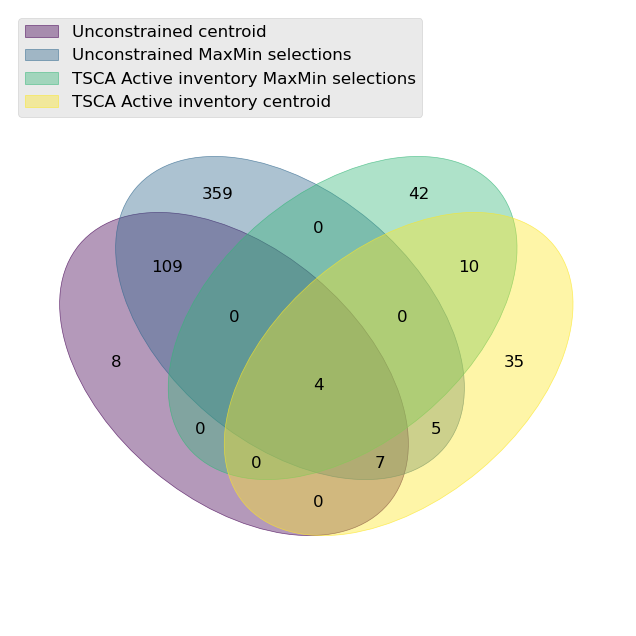

In [63]:
plt.style.use('ggplot')
f, ax = plt.subplots(figsize=(10, 8))
#plt.figure(figsize=(18, 8))
venn(mydict3, cmap="viridis", fontsize=12, legend_loc="upper left",ax = ax )
f.savefig(figures_dir+'Figure7_100524.png', dpi = 300)

In [60]:
mydict4 = {
          
           'TSCA inventory MaxMin selections' : set(final_df[final_df['MaxMin_tsca_picks']==1]['dtxsid'].tolist()),
           'TSCA inventory centroid' : set(final_df['tsca_centroid_id2'].unique().tolist()),
    'TSCA Active inventory MaxMin selections' : set(final_df[final_df['MaxMin_tsca_active_picks']==1]['dtxsid'].tolist()),
           'TSCA Active inventory centroid' : set(final_df['tsca_active_centroid_id2'].unique().tolist()),
           }

<Axes: >

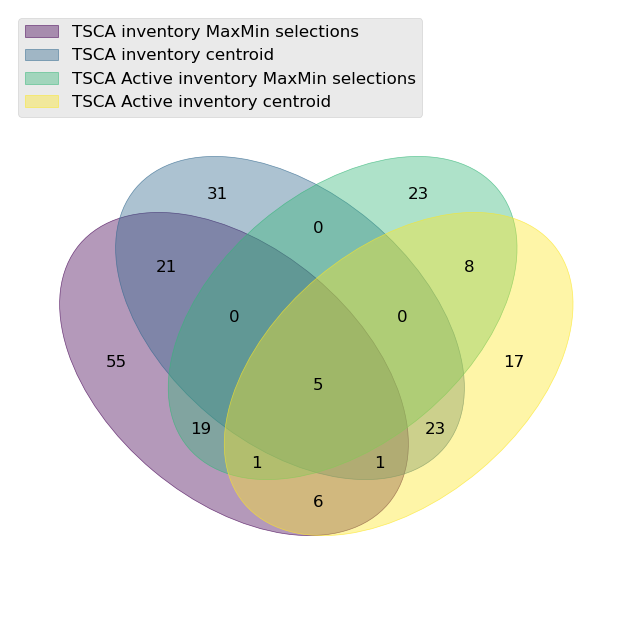

In [61]:
plt.style.use('ggplot')
f, ax = plt.subplots(figsize=(10, 8))
#plt.figure(figsize=(18, 8))
venn(mydict4, cmap="viridis", fontsize=12, legend_loc="upper left",ax = ax )
#f.savefig(figures_dir+'FigureS7a_220823.png', dpi = 300)